In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [50]:
# helper function

def spikize(seq):
    # find peaks
    spike = np.zeros_like(seq)
    spike[find_peaks(seq)[0]] = 1
    return spike

def diff_clip(seq):
    # do difference and clip to reconstruct the data format in the paper
    return np.clip(np.diff(seq,n=1),0,1)


In [34]:
data = np.load('./DonkeyKong/original_3510_512.npy', mmap_mode='r')

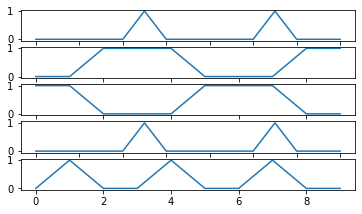

In [58]:
# transistor 362 (gate)
plt.subplot(611)
plt.plot(diff_clip(data[0])[30:45])

# transistor 1999 (gate)
plt.subplot(612)
plt.plot(data[1999][10:20])

# transistor 2558 (c1)
plt.subplot(613)
plt.plot(data[2558][10:20])

# transistor 452 (c2)
plt.subplot(614)
plt.plot(diff_clip(data[2673])[30:45])

# transistor 453 (c2)
plt.subplot(615)
plt.plot(diff_clip(data[453])[10:20])

# Sanity check

In [1]:
import numpy as np

In [40]:
causal = np.load("causality_3510_512.npy")
orig = np.load("original_3510_512_test.npy")

In [4]:
np.where(causal==-1)

(array([   0,    0,    0, ..., 3506, 3506, 3506]),
 array([   0,    0,    0, ..., 3506, 3506, 3506]),
 array([ 36,  37,  38, ..., 504, 505, 506]))

In [8]:
causal = np.where(causal==255, -1, causal)

In [9]:
print(causal.shape)
print(orig.shape)

(3510, 3510, 512)
(3510, 512)


## Post-cause analysis

In [11]:
import numpy as np
# original data
game = "DonkeyKong"
orig = np.load(f"./project/nmos_simulation/tests/{game}/original_3510_512.npy", mmap_mode='r')
causal = np.load(f"./project/nmos_simulation/tests/causality_3510_512.npy", mmap_mode='r')
high = np.load(f"./project/nmos_simulation/tests/{game}/high_3510_512.npy", mmap_mode='r')
low = np.load(f"./project/nmos_simulation/tests/{game}/low_3510_512.npy", mmap_mode='r')
causal = np.where(causal==255, -1, causal)

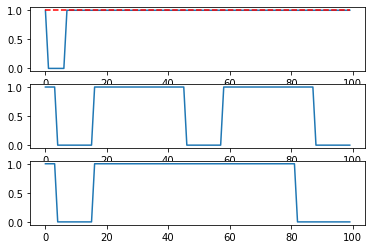

In [14]:
# find the start point where the original series is not 1
t_div = np.where(orig[0]!=1)[0][0]-1
t1 = 0
t2 = 12
length = 100
plt.figure()
plt.subplot(311)
plt.plot(orig[t1][t_div:t_div+length])
plt.plot(np.ones_like(orig[t1][t_div:t_div+length]), linestyle='--', color="red")
plt.subplot(312)
plt.plot(high[t1][t2][t_div:t_div+length])
plt.subplot(313)
plt.plot(orig[t2][t_div:t_div+length])

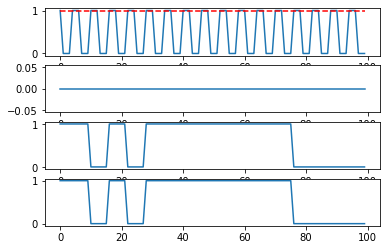

In [19]:
# find the start point where the original series is not 1
t_div = np.where(orig[0]!=1)[0][0]-1
t1 = 3057
t2 = 1647
length = 100
plt.figure()
plt.subplot(411)
plt.plot(orig[t1][t_div:t_div+length])
plt.plot(np.ones_like(orig[t1][t_div:t_div+length]), linestyle='--', color="red")
plt.subplot(412)
plt.plot(high[t1][t2][t_div:t_div+length])
plt.subplot(413)
plt.plot(orig[t2][t_div:t_div+length])
plt.subplot(414)
plt.plot(causal[t1][t2][t_div:t_div+length])

In [34]:
# calculate the effect of causal effect when turn high and turn low
# DEPRECATED version, use the new version in the make_effect_label.py
from tqdm import tqdm
causal = []
for i in tqdm(range(orig.shape[0])):
    if (orig[i]==1).all():
        # all 1, so turn low
        causal.append(low[i] - orig)
    elif (orig[i]==0).all():
        # all 0, so turn high
        causal.append(high[i] - orig)
    else:
        causal.append(high[i] - orig)
causal =  np.stack(causal)
causal = np.where(causal==255, -1, causal)
causal.shape
np.save("./project/nmos_inference/data_v4/causality_effect_512.npy", causal)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3510/3510 [00:03<00:00, 1007.99it/s]


## Make Label


In [23]:
# convert causal to causality label
# DEPRECATED version, use the new version in the make_effect_label.py
causal_label = [[1 if (causal[i, j]!=0).any() else 0 for j in range(causal.shape[1])]
                                                     for i in tqdm(range(causal.shape[0]))]
causal_label = np.stack(causal_label)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3510/3510 [00:37<00:00, 92.45it/s]


In [38]:
# convert causal to causality label based on only half clock from divergence point
causal_1c_label = []
for i in tqdm(range(causal.shape[0])):
    temp = []
    if (orig[i]==1).all():
        # become low at start
        t_div = 0
    elif (orig[i]==0).all():
        # become high at start
        t_div = 0
    else:
        t_div = np.where(orig[i]!=1)[0][0]
    for j in range(causal.shape[1]):
        if i == j:
            temp.append(0)
        else:
            if causal[i, j, t_div] != 0:
                temp.append(1)
            else:
                temp.append(0)
    causal_1c_label.append(temp)
causal_1c_label = np.stack(causal_1c_label)
causal_1c_label.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 3510/3510 [00:21<00:00, 162.87it/s]


(3510, 3510)

In [39]:
# calculate the positive and negative labels
print("positive labels: {}".format(sum(sum(causal_1c_label==1))))
print("negative labels: {}".format(sum(sum(causal_1c_label==0))))
np.save("./project/nmos_inference/data_v4/causal_1c_label.npy", causal_1c_label)

positive labels: 100469
negative labels: 12219631


In [40]:
np.where(causal_1c_label[0]==1)

(array([   6,  123,  395,  419, 1217, 1526, 1527, 1696, 1707, 2008, 2256,
        2668, 2673, 2819, 3135]),)